# Time series - introduction & ARIMA models

In this example, we'll explore parts of classical time series analysis and fit a few auto regressive models.

For more details on data transformation, model selection & forecasting [visit this site](http://people.duke.edu/~rnau/whatuse.htm)

In [0]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [0]:
pd.options.display.max_rows = 10
matplotlib.rcParams['figure.figsize'] = (15, 6)

First, mount the data folder in your google drive.
Make sure you have downloaded the data from here:

https://drive.google.com/open?id=1V1uNEs3IUNh3GxHzDBTrHEp7QyxT8yY7

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

We'll use a well-known air passengers time series for this example. Notice the date parsing function that allows us to build an index on this time series.

In [5]:
path = '/content/drive/My Drive/ml-college/time-series-analysis/data/AirPassengers.csv'
data = pd.read_csv(path, parse_dates=True, index_col='Month', date_parser=lambda x: pd.datetime.strptime(x, '%Y-%m'))
ts = data['#Passengers']
data

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Now let's see how the time series looks like (see inflation, trend and seasonality elements):

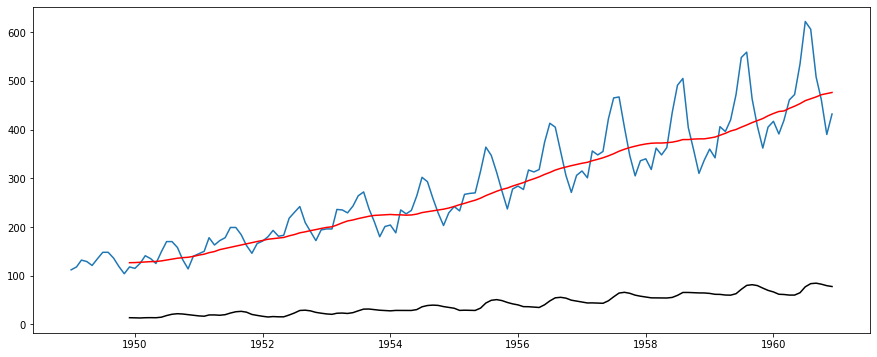

In [9]:
rolling = ts.rolling(center=False, window=12)        
plt.plot(ts)
plt.plot(rolling.mean(), color='red')
plt.plot(rolling.std(), color='black')
plt.show()

First, let's remove inflation by applying logarithm function:

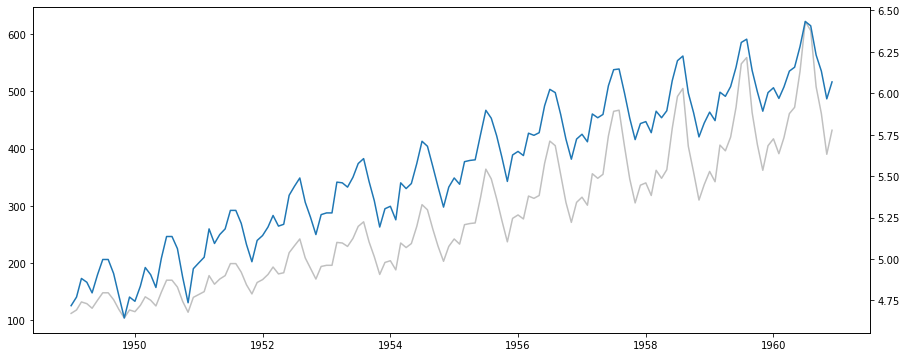

In [88]:
log_ts = np.log(ts)

plt.plot(ts, c='silver')
plt.twinx()
plt.plot(log_ts)
plt.show()

Next, we can try *seasonal_decompose* library function that can perform trend & seasonality decomposion at once.

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose(ts):
    
    decomposition = seasonal_decompose(ts, model='aditive')
    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    return decomposition

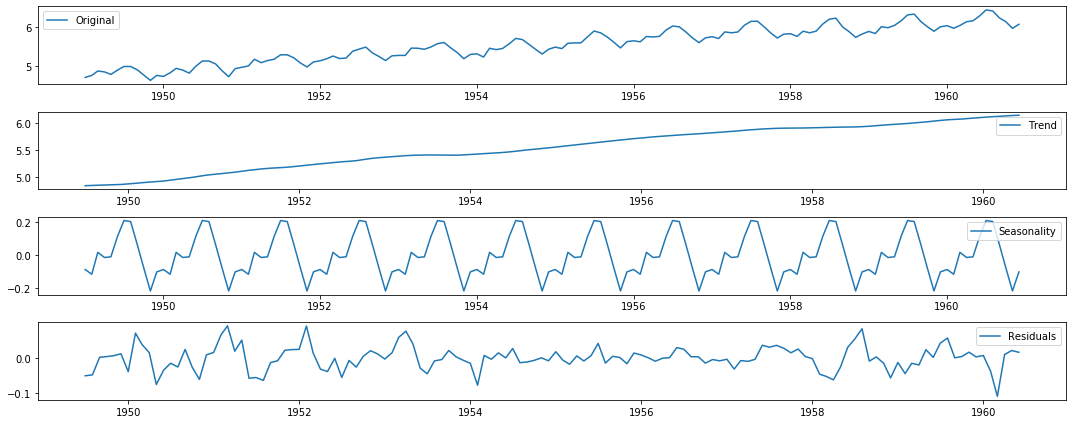

In [89]:
decomposition = decompose(log_ts)

## Forcasting from decomposition

We can use decomposed model for a simple forcasting. We would assume that in the future, trend and seasonality will repeat iteself. First let's focus on the trend:

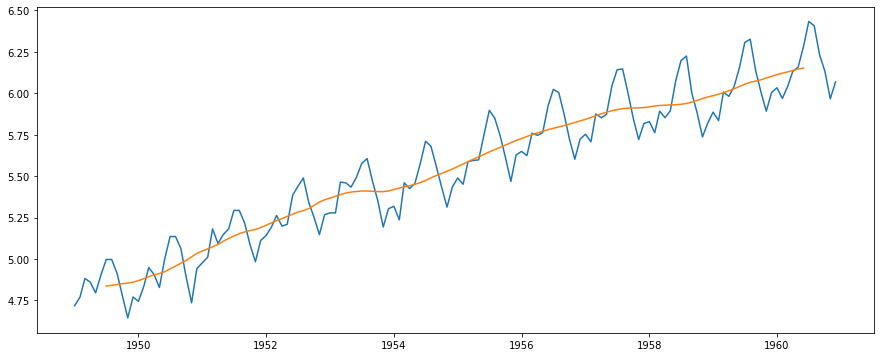

In [90]:
plt.plot(np.log(ts))
plt.plot(decomposition.trend)
plt.show()

We can approximate trend with simple linear regression (once the series is deflated with log. function)

In [0]:
from sklearn.linear_model import LinearRegression

X = np.expand_dims((ts.index - ts.index[0]).days, -1)
Y = log_ts

reg = LinearRegression().fit(X, Y)

Now we prepare a new date range (with extra two years for prediction) and predict trend

In [0]:
forcast_ts_index=pd.date_range(start='1949-01-01', periods=168, freq='MS')

In [0]:
x = np.expand_dims((forcast_ts_index - forcast_ts_index[0]).days, -1)
forcast_trend = pd.Series(reg.predict(x), index=forcast_ts_index)

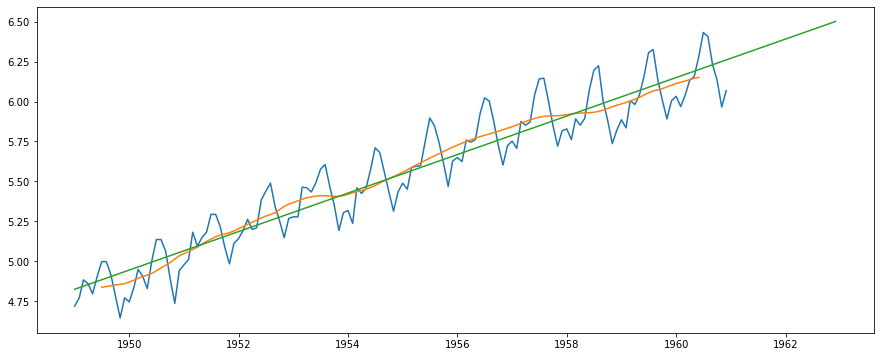

In [95]:
plt.plot(log_ts)
plt.plot(decomposition.trend)
plt.plot(forcast_trend)
plt.show()

Next, we can take thea last year of seasonal component and use it as a forcasted seasonal effect.

In [0]:
season = decomposition.seasonal.values[-12:]
forcast_season = np.concatenate((decomposition.seasonal.values, season, season))

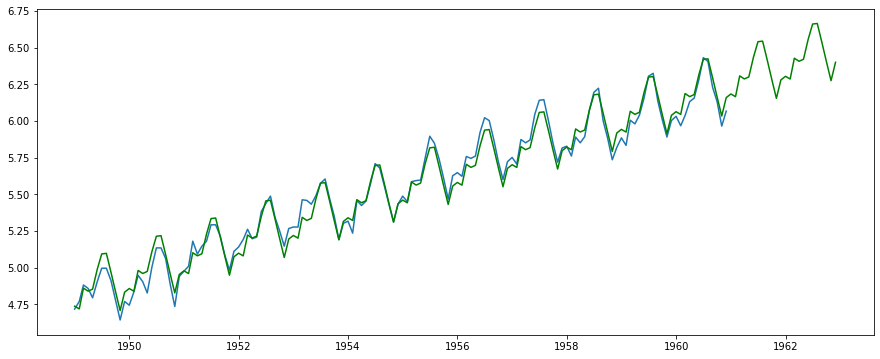

In [141]:
plt.plot(np.log(ts))
plt.plot(forcast_trend + forcast_season, color='g')
plt.show()

Last, we need to inflate the series again to return it into the correct # passengers domain.

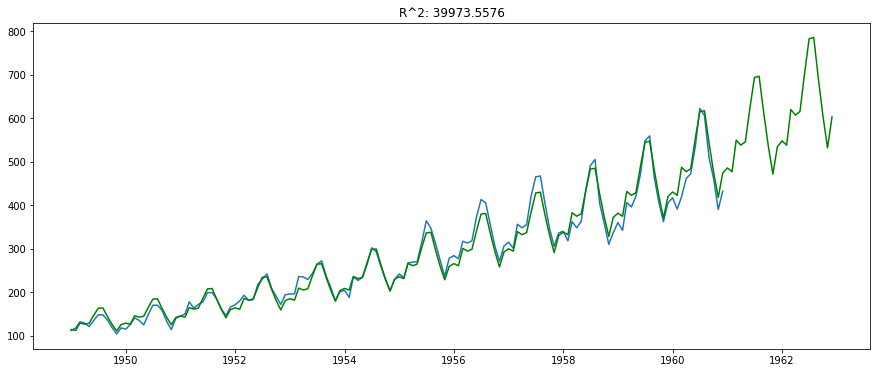

In [83]:
complete_forecast = np.exp(forcast_trend + forcast_season)
plt.plot(ts)
plt.plot(complete_forecast, color='g')
plt.title('R^2: %.4f'% sum((complete_forecast.values[:-24] - ts.values) ** 2))
plt.show()

## Model fitting

Let's try to fit an black-box model onto our data now. We need to make the time series *stationary* before.

Stationarity is a useful concept for forecasting as it explains some of the data and allow us to use certain forcasting models.

Time series is stationary if the following conditions are fulfilled:

1. The mean of the series should not be a function of time
2. The variance of the series should not a be a function of time
3. The covariance of the i-th term and the (i + k)-th term should not be a function of time

We can perform a statistical test to see if the time series is constant. The test is known as **Dickey Fuller** test.
We will run the test on the time series data and watch the *Test Statistic*. If it gets lower then the *Critical value*, we can reject the null hypothesis and say that the series is stationary.

In [0]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
        
    rolling = timeseries.rolling(center=False, window=12)        
    
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolling.mean(), color='red', label='Rolling Mean')
    plt.plot(rolling.std(), color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
        
    
    df_test = adfuller(timeseries, autolag='AIC')
    output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        
    for key, value in sorted(df_test[4].items(), key=lambda x: x[1], reverse=True):
        output['Critical Value (%s)' % key] = value
        
    print('Dickey-Fuller test:')    
    print(output)

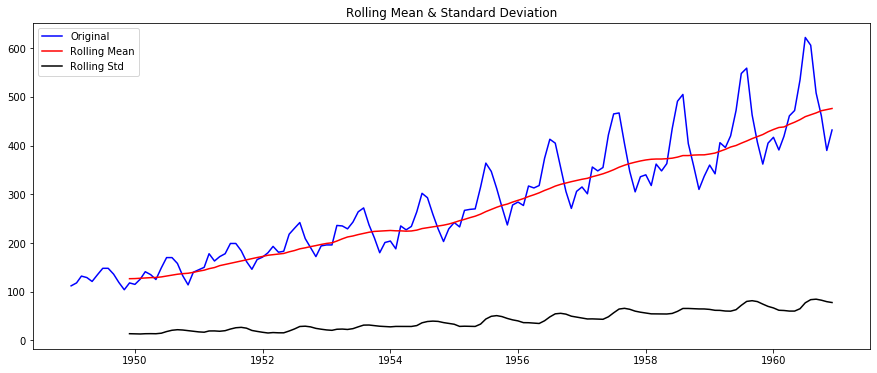

Dickey-Fuller test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (10%)            -2.578770
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
dtype: float64


In [44]:
test_stationarity(ts)

We can use log & difference transform to get rid of trend and time dependent variance. The stationarity test should reflect this transformation.

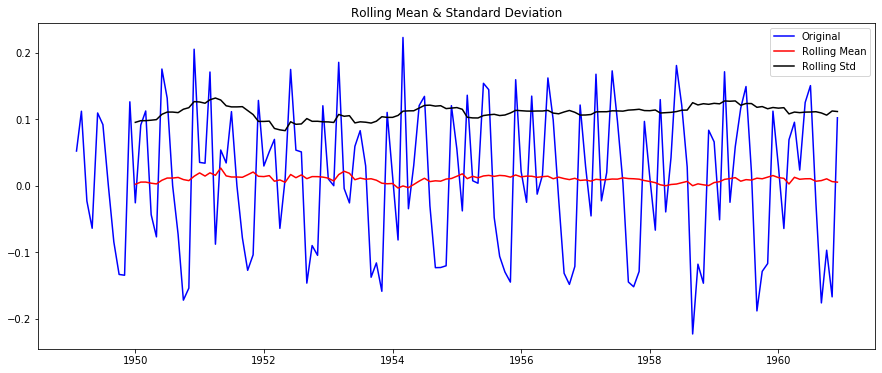

Dickey-Fuller test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (10%)            -2.578960
Critical Value (5%)             -2.884398
Critical Value (1%)             -3.482501
dtype: float64


In [45]:
ts_log = np.log(ts)
ts_log_diff = (ts_log - ts_log.shift()).dropna()

test_stationarity(ts_log_diff)

..now, we will fit the ARIMA model (**A**uto**R**egressive **I**ntegrated **M**oving **A**verage) to our data. Parameters can be set by inspection of auto-correlation and partial auto-correlation plots.

After the model is fitted, we can plot it over original data. Notice that we are still in the transformed space.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


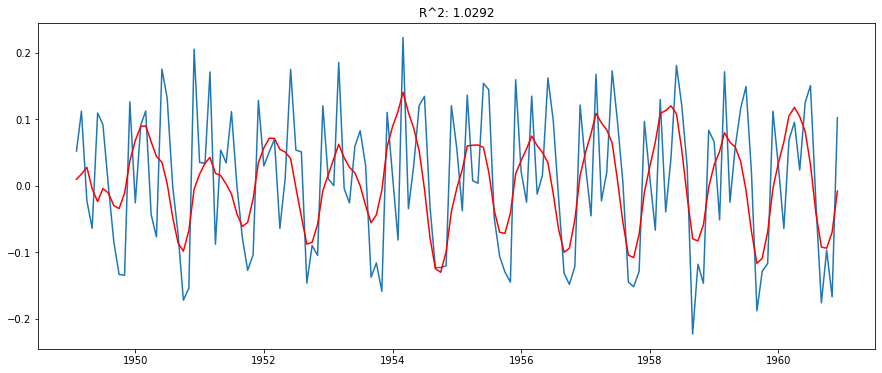

In [46]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log_diff, order=(2, 0, 2))  
results = model.fit()

plt.plot(ts_log_diff)
plt.plot(results.fittedvalues, c='r')
plt.title('R^2: %.4f'% sum((results.fittedvalues - ts_log_diff) ** 2))
plt.show()

Last step is to inverse-transform the data back to the original domain.

As we took a log & difference, we need to apply them in reverse order (i.e. cumulative sum & exp). Also, notice that with difference we lost the constant and we need to replace it with the first value of the original dataset.

Same apply for prediction out of the sample (to the future) whre we use the last datapoint from the original time series

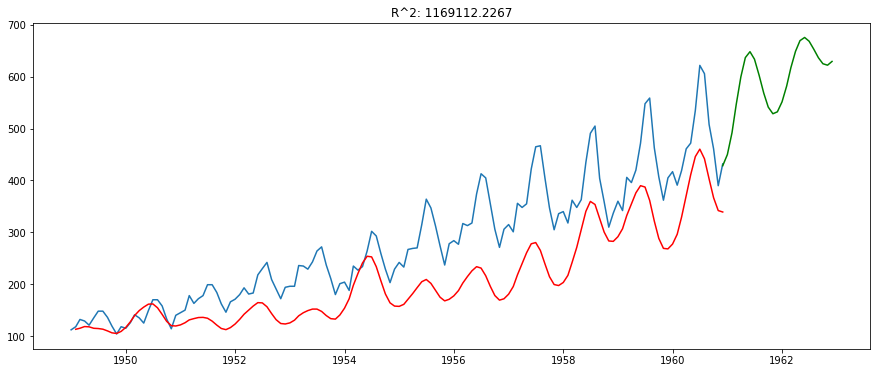

In [55]:
import datetime
from datetime import timedelta

prediction = results.predict(start=ts.index[-1], end=ts.index[-1] + timedelta(days=365 * 2), dynamic=True)
inflated = np.exp(results.fittedvalues.cumsum() + ts_log[0])

plt.plot(ts)
plt.plot(inflated, c='r')
plt.plot(np.exp(prediction.cumsum() + ts_log[-1]), c='g')
plt.title('R^2: %.4f'% sum((inflated - ts[1:]) ** 2))
plt.show()

There are more advanced models like SARIMAX, that separates the model for seasonal part. The usage is very similar although there are more hyper parameters to setup. One can use grid search to find to best combination of hyper parameters (not shown here).

As the model is a statistical one, The prediction plot may contain confidence intervals to see how certain the model is about its own prediction (gray area) i.e. according to the model, the prediction should be within the interval with 95% certainty.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


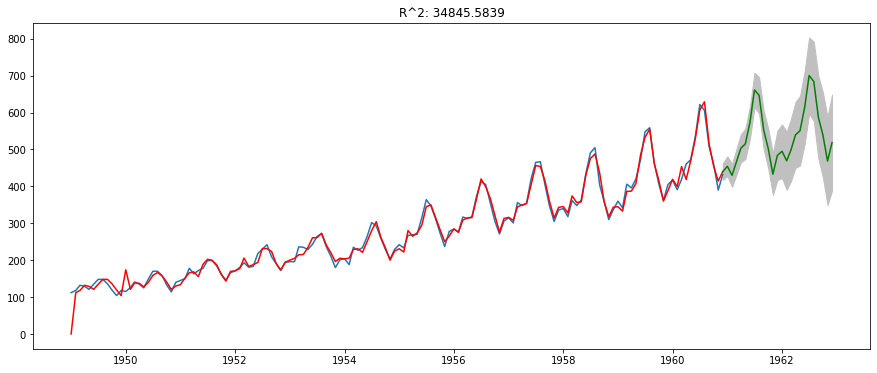

In [0]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

prediction = results.get_prediction(start=ts.index[-1], end=ts.index[-1] + timedelta(days=365 * 2), dynamic=True)
conf_int = prediction.conf_int(alpha=0.05)

plt.plot(ts)
plt.plot(results.fittedvalues, c='r')
plt.plot(prediction.predicted_mean, c='g')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='silver')
plt.title('R^2: %.4f'% sum((results.fittedvalues - ts) ** 2))
plt.show()